2.3 Percentual da Base de Dados para Treinamento

In [2]:
import pandas as pd

# Carregar os dados
df = pd.read_csv("C:/Users/Samsung/ENG4040/planilha_unificada.csv", sep=";")

# Selecionar colunas numéricas para imputação
colunas_numericas = ['OBITOS', 'AREA_DESMATADA_KM2', 'FRP', 'RISCOFOGO',
                     'PRECIPITACAO', 'DIASEMCHUVA', 'pm2.5_atm']

# Converter colunas para numérico e preencher nulos com a média do ano
for col in colunas_numericas:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby("ano")[col].transform(lambda x: x.fillna(x.mean()))

# Remover linhas com valores ainda ausentes
df = df.dropna(subset=colunas_numericas)

# Separar variáveis independentes e dependente
X = df[['AREA_DESMATADA_KM2', 'FRP', 'RISCOFOGO', 'PRECIPITACAO', 'DIASEMCHUVA', 'pm2.5_atm']]
y = df['OBITOS']

# Divisão temporal: treino com anos 2020–2022, teste com 2023
X_train = X[df['ano'] < 2023]
X_test = X[df['ano'] == 2023]
y_train = y[df['ano'] < 2023]
y_test = y[df['ano'] == 2023]

# Impressão dos tamanhos
print(f"Tamanho total da base: {len(df)}")
print(f"Amostras para treino (2020–2022): {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Amostras para teste (2023): {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")


Tamanho total da base: 1331
Amostras para treino (2020–2022): 979 (73.55%)
Amostras para teste (2023): 352 (26.45%)


Pré Processamento

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

# 1. Carregar os dados
df = pd.read_csv("C:/Users/Samsung/ENG4040/planilha_unificada.csv", sep=";")

# 2. Separar variáveis numéricas e categóricas
colunas_numericas = ['OBITOS', 'AREA_DESMATADA_KM2', 'FRP', 'RISCOFOGO',
                     'PRECIPITACAO', 'DIASEMCHUVA', 'pm2.5_atm']
colunas_categoricas = ['Categoria CID-10', 'QUALIDADE_AR_CLASSIFICADA']

# 3. Tratamento de valores ausentes
# 3.1 Numéricas → mediana por ano
for col in colunas_numericas:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby("ano")[col].transform(lambda x: x.fillna(x.median()))

# 3.2 Categóricas → moda
for col in colunas_categoricas:
    df[col] = df[col].fillna(df[col].mode()[0])

# 4. Detecção e tratamento de outliers numéricos (baseado no z-score)
for col in colunas_numericas:
    z = (df[col] - df[col].mean()) / df[col].std()
    df = df[np.abs(z) < 3]  # remove z > 3

# 5. Codificação de variáveis categóricas
# 5.1 One-Hot Encoding para 'QUALIDADE_AR_CLASSIFICADA'
df = pd.get_dummies(df, columns=['QUALIDADE_AR_CLASSIFICADA'], prefix='QUALIDADE')

# 5.2 Label Encoding para 'Categoria CID-10'
label_encoder = LabelEncoder()
df['CID10_ENCODED'] = label_encoder.fit_transform(df['Categoria CID-10'])

# 6. Separar variáveis explicativas e alvo
X = df[['AREA_DESMATADA_KM2', 'FRP', 'RISCOFOGO', 'PRECIPITACAO',
        'DIASEMCHUVA', 'pm2.5_atm', 'CID10_ENCODED'] + 
       [col for col in df.columns if col.startswith("QUALIDADE_")]]
y = df['OBITOS']

# 7. Separar treino (2020–2022) e teste (2023)
X_train = X[df['ano'] < 2023]
y_train = y[df['ano'] < 2023]
X_test = X[df['ano'] == 2023]
y_test = y[df['ano'] == 2023]

# 8. Normalização:
# - Z-score para variáveis com distribuição normal (padronização)
# - MinMax para variáveis com limites definidos

zscore_cols = ['FRP', 'pm2.5_atm', 'AREA_DESMATADA_KM2']
minmax_cols = ['RISCOFOGO', 'PRECIPITACAO', 'DIASEMCHUVA']

# Separar e escalar
scaler_z = StandardScaler()
scaler_minmax = MinMaxScaler()

X_train_z = scaler_z.fit_transform(X_train[zscore_cols])
X_test_z = scaler_z.transform(X_test[zscore_cols])

X_train_minmax = scaler_minmax.fit_transform(X_train[minmax_cols])
X_test_minmax = scaler_minmax.transform(X_test[minmax_cols])

# Combinar com colunas restantes (como categóricas já codificadas)
resto_cols = [col for col in X.columns if col not in zscore_cols + minmax_cols]
X_train_rest = X_train[resto_cols].reset_index(drop=True)
X_test_rest = X_test[resto_cols].reset_index(drop=True)

# Juntar tudo
X_train_final = pd.concat([
    pd.DataFrame(X_train_z, columns=zscore_cols),
    pd.DataFrame(X_train_minmax, columns=minmax_cols),
    X_train_rest
], axis=1)

X_test_final = pd.concat([
    pd.DataFrame(X_test_z, columns=zscore_cols),
    pd.DataFrame(X_test_minmax, columns=minmax_cols),
    X_test_rest
], axis=1)

# Resultado
print(f"Tamanho total da base final: {len(df)}")
print(f"Amostras de treino (2020–2022): {len(X_train_final)}")
print(f"Amostras de teste (2023): {len(X_test_final)}")



Tamanho total da base final: 1182
Amostras de treino (2020–2022): 903
Amostras de teste (2023): 279


5.1 Desempenho dos Algoritmos

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
import numpy as np

# 1. Remover variáveis com baixa variância (< 0.01)
filtro = VarianceThreshold(threshold=0.01)
X_train_filtrado = filtro.fit_transform(X_train)
X_test_filtrado = filtro.transform(X_test)
colunas_filtradas = X_train.columns[filtro.get_support()]

# 2. Definir os modelos (incluindo regressão linear múltipla)
modelos = {
    "Regressão Linear Múltipla": LinearRegression(),
    "Árvore de Regressão": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# 3. Avaliar os modelos com RMSE, MAE, R² e R² ajustado
resultados = []
n = len(y_test)
p = X_test_filtrado.shape[1]

for nome, modelo in modelos.items():
    modelo.fit(X_train_filtrado, y_train)
    y_pred = modelo.predict(X_test_filtrado)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    resultados.append({
        "Modelo": nome,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "R² Ajustado": r2_ajustado
    })

# 4. Mostrar resultados em tabela
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# 5. (Opcional) Mostrar features usadas
print("\nFeatures utilizadas na regressão linear múltipla:")
print(list(colunas_filtradas))


                      Modelo      RMSE       MAE        R²  R² Ajustado
0  Regressão Linear Múltipla  4.456511  2.678705  0.002246    -0.027318
1        Árvore de Regressão  3.822214  1.813620  0.266055     0.244308
2              Random Forest  2.755836  1.398387  0.618460     0.607155
3                    XGBoost  3.183934  1.621870  0.490714     0.475624

Features utilizadas na regressão linear múltipla:
['AREA_DESMATADA_KM2', 'FRP', 'PRECIPITACAO', 'DIASEMCHUVA', 'pm2.5_atm', 'CID10_ENCODED', 'QUALIDADE_Boa', 'QUALIDADE_Moderada']


 5.2 Análise das Variáveis

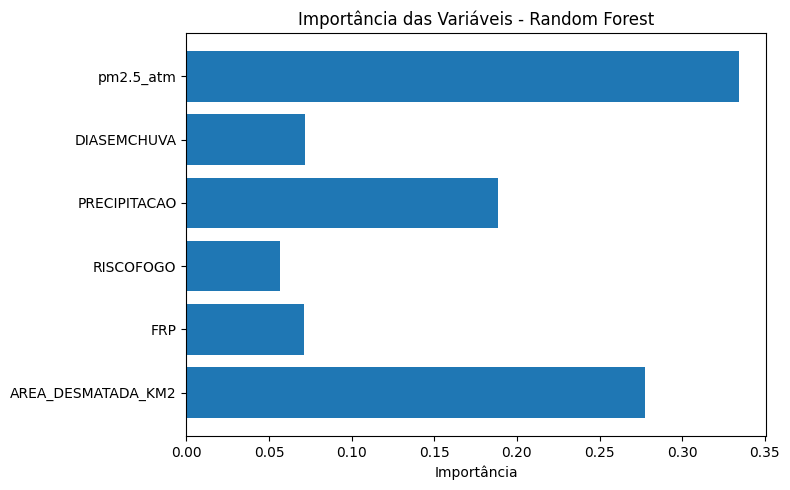

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Carregar os dados
df = pd.read_csv("C:/Users/Samsung/ENG4040/planilha_unificada.csv", sep=";")

# 2. Selecionar colunas relevantes
colunas_numericas = ['OBITOS', 'AREA_DESMATADA_KM2', 'FRP', 'RISCOFOGO',
                     'PRECIPITACAO', 'DIASEMCHUVA', 'pm2.5_atm']

# 3. Tratamento de valores ausentes (mediana para numéricas)
for col in colunas_numericas:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby("ano")[col].transform(lambda x: x.fillna(x.median()))

df = df.dropna(subset=colunas_numericas)

# 4. Separar variáveis preditoras e alvo
X = df[['AREA_DESMATADA_KM2', 'FRP', 'RISCOFOGO', 'PRECIPITACAO', 'DIASEMCHUVA', 'pm2.5_atm']]
y = df['OBITOS']

# 5. Normalização (padronização Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 7. Treinar o modelo Random Forest
modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X_train, y_train)

# 8. Obter importância das variáveis
importancias = modelo_rf.feature_importances_
variaveis = X.columns

# 9. Plotar gráfico
plt.figure(figsize=(8, 5))
plt.barh(variaveis, importancias)
plt.xlabel("Importância")
plt.title("Importância das Variáveis - Random Forest")
plt.tight_layout()
plt.show()


 5.9 Visualização dos Resultado

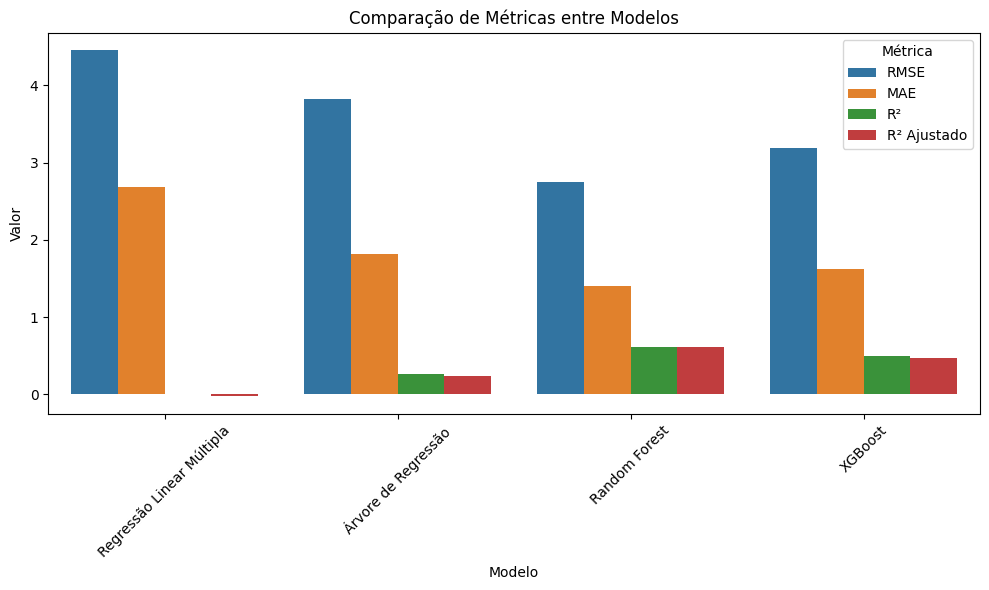

In [6]:
import seaborn as sns

# Comparação dos modelos com gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_resultados.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable")
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.legend(title="Métrica")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


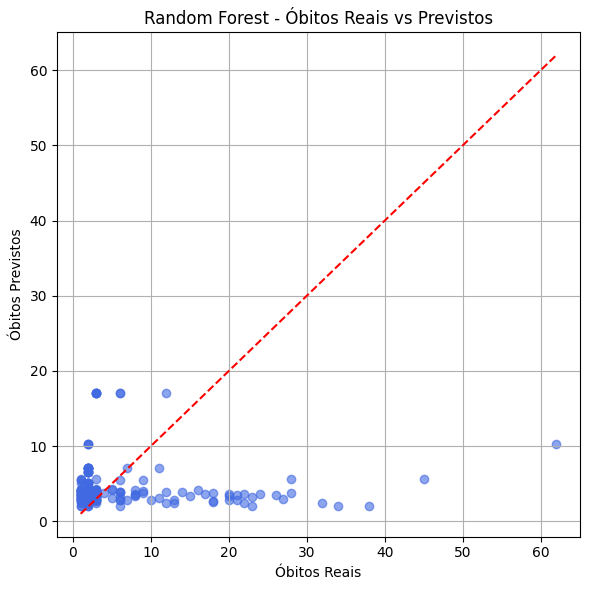

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Treinar modelo com os dados
modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

# Plot real vs previsto
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Linha ideal
plt.xlabel('Óbitos Reais')
plt.ylabel('Óbitos Previstos')
plt.title('Random Forest - Óbitos Reais vs Previstos')
plt.grid(True)
plt.tight_layout()
plt.show()


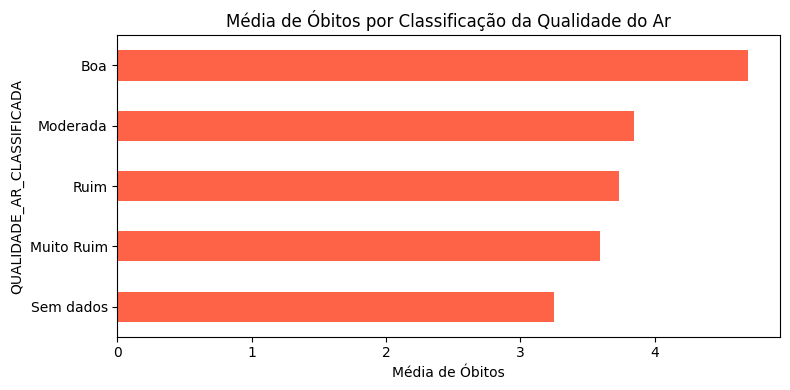

In [12]:
media_q_ar = df.groupby('QUALIDADE_AR_CLASSIFICADA')['OBITOS'].mean().sort_values()

plt.figure(figsize=(8, 4))
media_q_ar.plot(kind='barh', color='tomato')
plt.title("Média de Óbitos por Classificação da Qualidade do Ar")
plt.xlabel("Média de Óbitos")
plt.tight_layout()
plt.show()


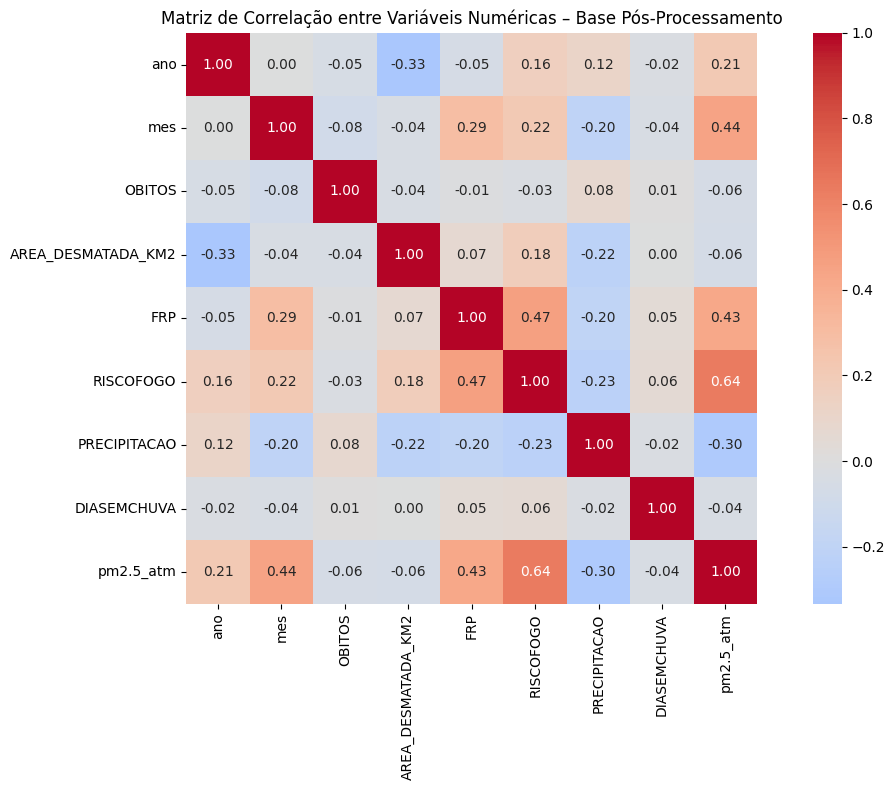

OBITOS                1.000000
PRECIPITACAO          0.076877
DIASEMCHUVA           0.008953
FRP                  -0.005961
RISCOFOGO            -0.030486
AREA_DESMATADA_KM2   -0.038581
ano                  -0.050731
pm2.5_atm            -0.056025
mes                  -0.084043
Name: OBITOS, dtype: float64


In [13]:


# Calcular a matriz de correlação apenas para variáveis numéricas
correlacao = df.corr(numeric_only=True)

# Plotar a matriz de correlação com foco em OBITOS
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Matriz de Correlação entre Variáveis Numéricas – Base Pós-Processamento")
plt.tight_layout()
plt.show()

# Para ver apenas a correlação com OBITOS
print(correlacao["OBITOS"].sort_values(ascending=False))